In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, OPTICS, Birch
from numba import njit, prange
import itertools

In [2]:
df = pd.read_csv("sample_dataset.csv")

In [3]:
df.head()

Location ID   Latitude  Longitude  Weight
0            1  35.844051  51.288501      10
1           51  35.615146  51.231918      15
2          101  35.843410  51.425973      50
3          151  35.802851  51.569993      20
4          201  35.671532  51.384217      11

## cluster based on 25 visitors
the number of points in each cluster should be approximately equal
the distance between the points in each cluster should be as small as possible
the distance between the clusters should be as large as possible
the total money spent by each cluster should be approximately equal

In [4]:
#normalize column 4 between 0 and 1
df['Weight'] = (df['Weight'] - df['Weight'].min()) / (df['Weight'].max() - df['Weight'].min())
df['Weight'].head()

0    0.183673
1    0.285714
2    1.000000
3    0.387755
4    0.204082
Name: Weight, dtype: float64

In [14]:
df['Weight'].describe()

count    5000.000000
mean        0.505335
std         0.294791
min         0.000000
25%         0.244898
50%         0.510204
75%         0.755102
max         1.000000
Name: Weight, dtype: float64

In [5]:
df = df.dropna()
model = AgglomerativeClustering(n_clusters=25, affinity='euclidean', linkage='ward').fit(df.iloc[:, 1:3])

In [6]:
df["cluster"] = model.labels_
df["cluster"].value_counts()

0     378
4     282
2     274
5     264
11    247
1     244
9     227
12    222
17    221
3     214
8     211
13    199
6     197
14    180
7     180
18    177
19    163
15    162
24    153
16    145
21    139
22    135
10    134
23    128
20    124
Name: cluster, dtype: int64

## plot the clusters

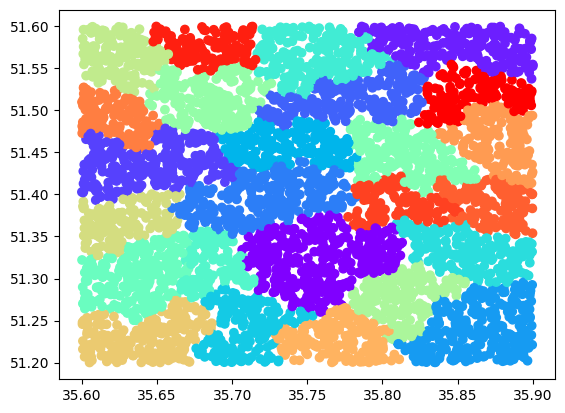

In [7]:
plt.scatter(df.iloc[:, 1], df.iloc[:, 2], c=model.labels_, cmap="rainbow")

In [8]:
model_with_weight = AgglomerativeClustering(n_clusters=25, affinity='euclidean', linkage='ward').fit(df.iloc[:, 1:4])

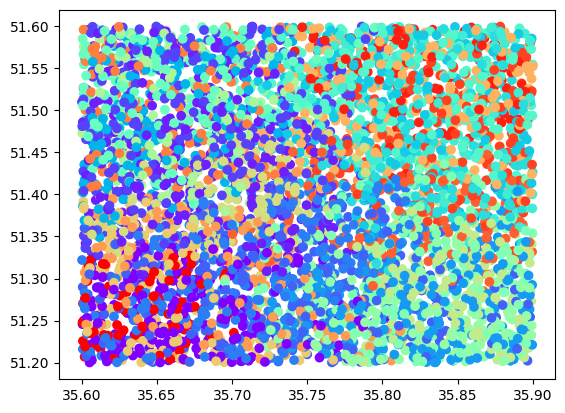

In [9]:
plt.scatter(df.iloc[:, 1], df.iloc[:, 2], c=model_with_weight.labels_, cmap="rainbow")

In [10]:
def cluster_data(data, min_cluster_size, max_cluster_size):
    cluster_sizes = range(min_cluster_size, max_cluster_size)
    models = []
    for size in cluster_sizes:
        model = AgglomerativeClustering(n_clusters=size, affinity='euclidean', linkage='ward').fit(data)
        models.append(model)
    return models

In [11]:
models = cluster_data(df.iloc[:, 1:4], 2, 50)

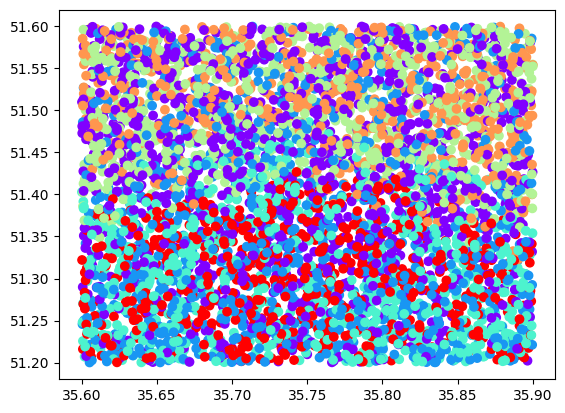

In [12]:
plt.scatter(df.iloc[:, 1], df.iloc[:, 2], c=models[4].labels_, cmap="rainbow")

In [13]:
# show sum of weights for each cluster
df.groupby("cluster")["Weight"].sum()

cluster
0     196.081633
1     123.306122
2     139.285714
3     102.061224
4     149.408163
5     138.102041
6      91.938776
7      92.469388
8     114.346939
9     120.612245
10     67.448980
11    124.346939
12    112.755102
13     97.612245
14     88.734694
15     83.918367
16     70.142857
17    106.857143
18     86.142857
19     81.224490
20     63.040816
21     69.857143
22     66.408163
23     61.122449
24     79.448980
Name: Weight, dtype: float64

In [15]:
# the number of locations in each cluster
df.groupby("cluster")["cluster"].count()

cluster
0     378
1     244
2     274
3     214
4     282
5     264
6     197
7     180
8     211
9     227
10    134
11    247
12    222
13    199
14    180
15    162
16    145
17    221
18    177
19    163
20    124
21    139
22    135
23    128
24    153
Name: cluster, dtype: int64

In [16]:
# locations in cluster 0
df[df["cluster"] == 0]

Location ID   Latitude  Longitude    Weight  cluster
7             351  35.773799  51.348802  0.795918        0
9             451  35.715674  51.334875  0.979592        0
12            601  35.773110  51.289228  0.183673        0
19            951  35.722580  51.329223  0.693878        0
20           1001  35.751979  51.364249  0.061224        0
...           ...        ...        ...       ...      ...
4960         3050  35.714159  51.327497  0.306122        0
4967         3400  35.746752  51.371500  0.897959        0
4978         3950  35.730130  51.335232  0.714286        0
4993         4700  35.737420  51.337044  0.040816        0
4995         4800  35.791427  51.347107  0.061224        0

[378 rows x 5 columns]


## calculate shortest path between all locations in a cluster based on their coordinates
### (traveling salesman problem)


In [59]:
def distance_between_points(point1, point2):
    print(point1, point2)
    lat1, lon1 = point1
    lat2, lon2 = point2
    radius = 6371  # km

    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    sin_dlat = np.sin(dlat / 2)
    sin_dlon = np.sin(dlon / 2)
    cos_lat1 = np.cos(np.radians(lat1))
    cos_lat2 = np.cos(np.radians(lat2))

    a = sin_dlat * sin_dlat + cos_lat1 * cos_lat2 * sin_dlon * sin_dlon
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = radius * c

    return d


In [63]:
def calculate_shortest_path(locations):
    shortest_distance = math.inf
    shortest_path = None
    for path in itertools.permutations(locations):
        distance = 0
        for i in range(len(path) - 1):
            distance += distance_between_points(path[i], path[i + 1])
            if distance > shortest_distance:
                break  # Exit early if the distance exceeds the current shortest distance
        if distance < shortest_distance:
            shortest_distance = distance
            shortest_path = path
    return shortest_path, shortest_distance


In [64]:
# shortest path for cluster 0
calculate_shortest_path(df[df["cluster"] == 20][["Latitude", "Longitude"]].values)

[35.608087 51.510755] [35.600123 51.510025]
[35.600123 51.510025] [35.617217 51.504693]
[35.617217 51.504693] [35.623811 51.524448]
[35.623811 51.524448] [35.603427 51.484701]
[35.603427 51.484701] [35.625318 51.481259]
[35.625318 51.481259] [35.611539 51.51244 ]
[35.611539 51.51244 ] [35.632594 51.468018]
[35.632594 51.468018] [35.617757 51.471719]
[35.617757 51.471719] [35.638349 51.457336]
[35.638349 51.457336] [35.639239 51.494897]
[35.639239 51.494897] [35.615078 51.519068]
[35.615078 51.519068] [35.60326  51.524929]
[35.60326  51.524929] [35.629903 51.487825]
[35.629903 51.487825] [35.639855 51.502776]
[35.639855 51.502776] [35.612616 51.490151]
[35.612616 51.490151] [35.601408 51.476857]
[35.601408 51.476857] [35.621049 51.484237]
[35.621049 51.484237] [35.640729 51.454677]
[35.640729 51.454677] [35.613141 51.486175]
[35.613141 51.486175] [35.602785 51.490221]
[35.602785 51.490221] [35.640993 51.499414]
[35.640993 51.499414] [35.600679 51.486116]
[35.600679 51.486116] [35.627644

[35.637056 51.481668] [35.601102 51.513257]
[35.601102 51.513257] [35.614062 51.490214]
[35.614062 51.490214] [35.643112 51.470591]
[35.643112 51.470591] [35.631787 51.500751]
[35.631787 51.500751] [35.616584 51.477436]
[35.616584 51.477436] [35.614174 51.479977]
[35.614174 51.479977] [35.608392 51.484696]
[35.608392 51.484696] [35.634372 51.484318]
[35.634372 51.484318] [35.642988 51.487168]
[35.642988 51.487168] [35.623398 51.47636 ]
[35.623398 51.47636 ] [35.601332 51.527476]
[35.601332 51.527476] [35.62339  51.478583]
[35.62339  51.478583] [35.634183 51.51248 ]
[35.634183 51.51248 ] [35.630277 51.491678]
[35.630277 51.491678] [35.623956 51.496976]
[35.623956 51.496976] [35.622283 51.500822]
[35.622283 51.500822] [35.633951 51.508558]
[35.633951 51.508558] [35.632215 51.514132]
[35.632215 51.514132] [35.645005 51.458488]
[35.645005 51.458488] [35.636101 51.463169]
[35.636101 51.463169] [35.600772 51.505833]
[35.600772 51.505833] [35.615961 51.502524]
[35.615961 51.502524] [35.606149

KeyboardInterrupt: 